In [ ]:
# Run below commands to download the spark from apache website
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar xf spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
# command to list out the downlaoded cofing files for  the spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9f2fe2269faeea5fa518fce71f2288521408191fc53659cf60c963768f2ef4f4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
#initialising Spark
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
train_df = spark.read.csv("/content/drive/MyDrive/Copy of train 1.csv", header="True", inferSchema="True")


In [54]:
train_df.show()

+-------+--------------------+--------------------+----------+
|user_id|          movie_name|              review|sentiment |
+-------+--------------------+--------------------+----------+
|     90|          The Matrix|Dated and uninspi...|  negative|
|      1|The Shawshank Red...|One of the best m...|  positive|
|    128|        Pulp Fiction|Overrated and sel...|  negative|
|      2|       The Godfather|A classic masterp...|  positive|
|      4|     The Dark Knight|Incredible action...|  positive|
|     91|          Goodfellas|Predictable and d...|  negative|
|      5|    Schindler's List|Emotional and pow...|  positive|
|      6|        Forrest Gump|Heartwarming and ...|  positive|
|      7|          Fight Club|Intense and thoug...|  positive|
|      8|The Lord of the R...|Epic fantasy adve...|  positive|
|    126|The Shawshank Red...|Overhyped and bor...|  negative|
|      9|           Inception|Mind-bending and ...|  positive|
|     10|          The Matrix|Revolutionary and...|  po

In [55]:
train_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_name: string (nullable = true)
 |-- review: string (nullable = true)
 |-- sentiment : string (nullable = true)



In [60]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, Tokenizer
from pyspark.ml.feature import StringIndexer, VectorAssembler, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayesModel, NaiveBayes, LinearSVC
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
from pyspark.sql.functions import col, when, expr, ceil, floor, round

In [ ]:
tokenizer = Tokenizer(inputCol="review", outputCol="words")
train_wordsdata = tokenizer.transform(train_df)
#test_wordsdata = tokenizer.transform(test_df)

In [67]:
train_wordsdata.show()

+-------+--------------------+--------------------+----------+--------------------+
|user_id|          movie_name|              review|sentiment |               words|
+-------+--------------------+--------------------+----------+--------------------+
|     90|          The Matrix|Dated and uninspi...|  negative|[dated, and, unin...|
|      1|The Shawshank Red...|One of the best m...|  positive|[one, of, the, be...|
|    128|        Pulp Fiction|Overrated and sel...|  negative|[overrated, and, ...|
|      2|       The Godfather|A classic masterp...|  positive|[a, classic, mast...|
|      4|     The Dark Knight|Incredible action...|  positive|[incredible, acti...|
|     91|          Goodfellas|Predictable and d...|  negative|[predictable, and...|
|      5|    Schindler's List|Emotional and pow...|  positive|[emotional, and, ...|
|      6|        Forrest Gump|Heartwarming and ...|  positive|[heartwarming, an...|
|      7|          Fight Club|Intense and thoug...|  positive|[intense, and,

In [68]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
train_filtered_data = remover.transform(train_wordsdata)
#test_filtered_data = remover.transform(test_wordsdata)

In [69]:
train_filtered_data.show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+
|user_id|          movie_name|              review|sentiment |               words|            filtered|
+-------+--------------------+--------------------+----------+--------------------+--------------------+
|     90|          The Matrix|Dated and uninspi...|  negative|[dated, and, unin...|[dated, uninspiri...|
|      1|The Shawshank Red...|One of the best m...|  positive|[one, of, the, be...|[one, best, movie...|
|    128|        Pulp Fiction|Overrated and sel...|  negative|[overrated, and, ...|[overrated, self-...|
|      2|       The Godfather|A classic masterp...|  positive|[a, classic, mast...|[classic, masterp...|
|      4|     The Dark Knight|Incredible action...|  positive|[incredible, acti...|[incredible, acti...|
|     91|          Goodfellas|Predictable and d...|  negative|[predictable, and...|[predictable, dull.]|
|      5|    Schindler's List|Emotional and pow...|  po

In [17]:
from pyspark.ml.feature import HashingTF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawfeatures", numFeatures=10000)
train_featurized_data = hashingTF.transform(train_filtered_data)
#test_featurized_data = hashingTF.transform(test_filtered_data)


In [62]:
train_featurized_data.show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|user_id|          movie_name|              review|sentiment |               words|            filtered|         rawfeatures|
+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|     90|          The Matrix|Dated and uninspi...|  negative|[dated, and, unin...|[dated, uninspiri...|(10000,[6281,7652...|
|      1|The Shawshank Red...|One of the best m...|  positive|[one, of, the, be...|[one, best, movie...|(10000,[763,815,1...|
|    128|        Pulp Fiction|Overrated and sel...|  negative|[overrated, and, ...|[overrated, self-...|(10000,[158,7264]...|
|      2|       The Godfather|A classic masterp...|  positive|[a, classic, mast...|[classic, masterp...|(10000,[4697,7158...|
|      4|     The Dark Knight|Incredible action...|  positive|[incredible, acti...|[incredible, acti...|(10000,[3263,5

In [ ]:
idf = IDF(inputCol="rawfeatures", outputCol="features")
idf_model = idf.fit(train_featurized_data)
train_rescaled_data = idf_model.transform(train_featurized_data)
#test_rescaled_data = idf_model.transform(test_featurized_data)

In [ ]:
train_rescaled_data.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_name: string (nullable = true)
 |-- review: string (nullable = true)
 |-- sentiment : string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawfeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [19]:

indexer = StringIndexer(inputCol="sentiment ", outputCol="label")
indexer_model = indexer.fit(train_rescaled_data)
train_indexed_data = indexer_model.transform(train_rescaled_data)
#test_indexed_data = indexer_model.transform(test_rescaled_data)

In [63]:
train_indexed_data.show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|user_id|          movie_name|              review|sentiment |               words|            filtered|         rawfeatures|            features|label|
+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|     90|          The Matrix|Dated and uninspi...|  negative|[dated, and, unin...|[dated, uninspiri...|(10000,[6281,7652...|(10000,[6281,7652...|  1.0|
|      1|The Shawshank Red...|One of the best m...|  positive|[one, of, the, be...|[one, best, movie...|(10000,[763,815,1...|(10000,[763,815,1...|  0.0|
|    128|        Pulp Fiction|Overrated and sel...|  negative|[overrated, and, ...|[overrated, self-...|(10000,[158,7264]...|(10000,[158,7264]...|  1.0|
|      2|       The Godfather|A classic masterp...|  positive|[a, classic, mast...

In [21]:
#split dataset into train and test
train_data, test_data = train_indexed_data.randomSplit([0.6,0.4], seed=42)

In [22]:
train_data.show()
#test_data.show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|user_id|          movie_name|              review|sentiment |               words|            filtered|         rawfeatures|            features|label|
+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|      2|       The Godfather|A classic masterp...|  positive|[a, classic, mast...|[classic, masterp...|(10000,[4697,7158...|(10000,[4697,7158...|  0.0|
|      5|    Schindler's List|Emotional and pow...|  positive|[emotional, and, ...|[emotional, power...|(10000,[5855,8322...|(10000,[5855,8322...|  0.0|
|      7|          Fight Club|Intense and thoug...|  positive|[intense, and, th...|[intense, thought...|(10000,[5291,9660...|(10000,[5291,9660...|  0.0|
|      9|           Inception|Mind-bending and ...|  positive|[mind-bending, an...

In [64]:
test_data.show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|user_id|          movie_name|              review|sentiment |               words|            filtered|         rawfeatures|            features|label|
+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|      1|The Shawshank Red...|One of the best m...|  positive|[one, of, the, be...|[one, best, movie...|(10000,[763,815,1...|(10000,[763,815,1...|  0.0|
|      4|     The Dark Knight|Incredible action...|  positive|[incredible, acti...|[incredible, acti...|(10000,[3263,5040...|(10000,[3263,5040...|  0.0|
|      6|        Forrest Gump|Heartwarming and ...|  positive|[heartwarming, an...|[heartwarming, to...|(10000,[2363,7384...|(10000,[2363,7384...|  0.0|
|      8|The Lord of the R...|Epic fantasy adve...|  positive|[epic, fantasy, a...

In [29]:
lr = LogisticRegression(featuresCol="features", labelCol="label",maxIter=10)
lr_model = lr.fit(train_data)


In [57]:
predictions = lr_model.transform(test_data)

In [70]:
predictions.show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|user_id|          movie_name|              review|sentiment |               words|            filtered|         rawfeatures|            features|label|       rawPrediction|         probability|prediction|
+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|      1|The Shawshank Red...|One of the best m...|  positive|[one, of, the, be...|[one, best, movie...|(10000,[763,815,1...|(10000,[763,815,1...|  0.0|[0.86470318597814...|[0.70364234717418...|       0.0|
|      4|     The Dark Knight|Incredible action...|  positive|[incredible, acti...|[incredible, acti...|(10000,[3263,5040...|(10000,[3263,5040...|  0.0|[0.86470318597814...|[0.

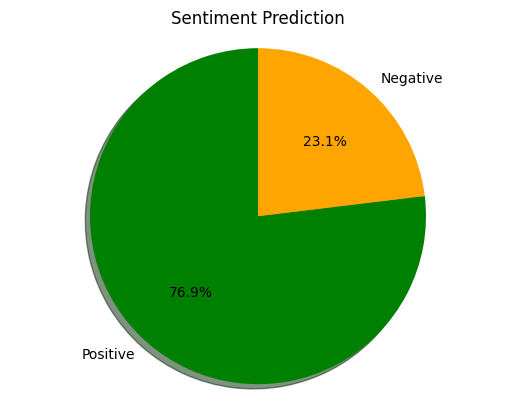

In [71]:
import matplotlib.pyplot as plt

positive_count = predictions.filter(predictions['prediction'] == 0).count()
negative_count = predictions.filter(predictions['prediction'] == 1).count()
total_count = positive_count + negative_count

labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
colors = ['green', 'orange']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Sentiment Prediction')
plt.show()

In [32]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy", accuracy)

Accuracy 0.9230769230769231


In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [35]:
accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9230769230769231
Precision: 0.9307692307692308
Recall: 0.9230769230769231
F1 Score: 0.9196067090803934


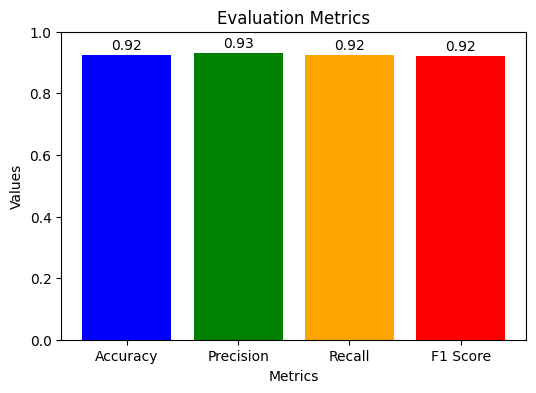

In [36]:
categories = ["Accuracy", 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(6,4))
bars = plt.bar(categories, values, color=['blue', 'green', 'orange', 'red'])

for bar, values in zip(bars, values):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{values:.2f}', ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.show()

In [39]:
#no of positive and negative reviews for idividual movies
movie_sentiment_count = train_indexed_data.groupBy("movie_name", "sentiment ").count()

In [40]:
movie_sentiment_count.show(50)

+--------------------+----------+-----+
|          movie_name|sentiment |count|
+--------------------+----------+-----+
|          Fight Club|  positive|    6|
|        Pulp Fiction|  negative|    5|
|The Lord of the R...|  positive|    6|
|The Silence of th...|  positive|    5|
|        Forrest Gump|  positive|    6|
|The Silence of th...|  negative|    3|
|        The Departed|  positive|    5|
|       The Godfather|  negative|    1|
|       The Godfather|  positive|    6|
|        Pulp Fiction|  positive|    3|
|The Lord of the R...|  negative|    3|
|          Fight Club|  negative|    3|
| Saving Private Ryan|  positive|    3|
|           Inception|  positive|    6|
|    Schindler's List|  positive|    6|
|     The Dark Knight|  negative|    2|
|        Forrest Gump|  negative|    3|
|          The Matrix|  negative|    4|
|          The Matrix|  positive|    6|
|The Shawshank Red...|  positive|    6|
|           Gladiator|  positive|    6|
|           Gladiator|  negative|    2|


In [46]:
#total_count = movie_sentiment_count.groupBy("movie_name") \
 #            .agg(sum(when(col("sentiment ") == "positive", col("count"))).alias("total_positive_count"),
  #                sum(when(col("sentiment ") == "negative", col("count"))).alias("total_negative_count")) \
   #          .fillna(0)

   #seperate count column for both positive and negative
total_count = movie_sentiment_count.groupBy("movie_name").pivot("sentiment ").sum("count").fillna(0)


In [47]:
total_count.show()

+--------------------+--------+--------+
|          movie_name|negative|positive|
+--------------------+--------+--------+
|        The Departed|       0|       5|
|           Gladiator|       2|       6|
|       The Godfather|       1|       6|
|     The Dark Knight|       2|       6|
|          Goodfellas|       7|       1|
|        Pulp Fiction|       5|       3|
|        Forrest Gump|       3|       6|
|The Shawshank Red...|       3|       6|
|The Silence of th...|       3|       5|
|The Lord of the R...|       3|       6|
|          The Matrix|       4|       6|
| Saving Private Ryan|       5|       3|
|    Schindler's List|       2|       6|
|           Inception|       3|       6|
|          Fight Club|       3|       6|
+--------------------+--------+--------+



In [48]:
total_review = total_count.withColumn("Total_review", (expr("positive + negative")))

In [49]:
total_review.show()

+--------------------+--------+--------+------------+
|          movie_name|negative|positive|Total_review|
+--------------------+--------+--------+------------+
|        The Departed|       0|       5|           5|
|           Gladiator|       2|       6|           8|
|       The Godfather|       1|       6|           7|
|     The Dark Knight|       2|       6|           8|
|          Goodfellas|       7|       1|           8|
|        Pulp Fiction|       5|       3|           8|
|        Forrest Gump|       3|       6|           9|
|The Shawshank Red...|       3|       6|           9|
|The Silence of th...|       3|       5|           8|
|The Lord of the R...|       3|       6|           9|
|          The Matrix|       4|       6|          10|
| Saving Private Ryan|       5|       3|           8|
|    Schindler's List|       2|       6|           8|
|           Inception|       3|       6|           9|
|          Fight Club|       3|       6|           9|
+--------------------+------

In [50]:
#Rating calculation

Rating = total_review.withColumn("rating", round(
    (total_review["positive"] * 5 + total_review["negative"] * 0) / total_review["Total_review"], 2))

In [51]:
Rating.show()

+--------------------+--------+--------+------------+------+
|          movie_name|negative|positive|Total_review|rating|
+--------------------+--------+--------+------------+------+
|        The Departed|       0|       5|           5|   5.0|
|           Gladiator|       2|       6|           8|  3.75|
|       The Godfather|       1|       6|           7|  4.29|
|     The Dark Knight|       2|       6|           8|  3.75|
|          Goodfellas|       7|       1|           8|  0.63|
|        Pulp Fiction|       5|       3|           8|  1.88|
|        Forrest Gump|       3|       6|           9|  3.33|
|The Shawshank Red...|       3|       6|           9|  3.33|
|The Silence of th...|       3|       5|           8|  3.13|
|The Lord of the R...|       3|       6|           9|  3.33|
|          The Matrix|       4|       6|          10|   3.0|
| Saving Private Ryan|       5|       3|           8|  1.88|
|    Schindler's List|       2|       6|           8|  3.75|
|           Inception|  

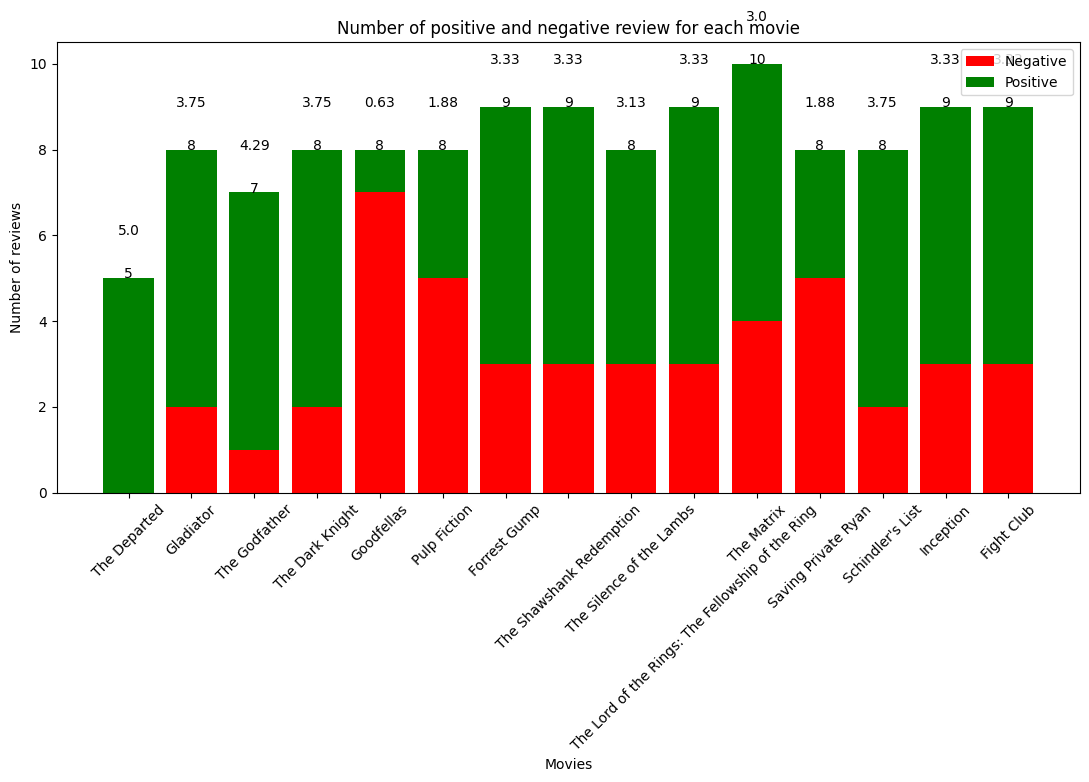

In [53]:
movie_names = Rating.select("movie_name").rdd.flatMap(lambda x: x).collect()
negative_reviews = Rating.select("negative").rdd.flatMap(lambda x: x).collect()
positive_reviews = Rating.select("positive").rdd.flatMap(lambda x: x).collect()
total_review = Rating.select("Total_review").rdd.flatMap(lambda x: x).collect()
rating = Rating.select("rating").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(11,8))

plt.bar(movie_names, negative_reviews, color='red', label='Negative')
plt.bar(movie_names, positive_reviews, bottom=negative_reviews, color='green', label='Positive')

for i in range(len(movie_names)):
   plt.text(i, negative_reviews[i] + positive_reviews[i], str(total_review[i]), ha = 'center')
   plt.text(i, total_review[i] + 1, str(rating[i]), ha = 'center')

plt.xlabel('Movies')
plt.ylabel('Number of reviews')
plt.title('Number of positive and negative review for each movie')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import expr
TP = predictions.filter((predictions["prediction"] ==1) & (predictions["label"] ==1)).count()
TN = predictions.filter((predictions["prediction"] ==0) & (predictions["label"] ==0)).count()
FP = predictions.filter((predictions["prediction"] ==1) & (predictions["label"] ==0)).count()
FN = predictions.filter((predictions["prediction"] ==0) & (predictions["label"] ==1)).count()

print("True Positive", TP)
print("True Negative", TN)
print("False Positive", FP)
print("False Negative", FN)

True Positive 12
True Negative 36
False Positive 0
False Negative 4


In [ ]:
A = FN = predictions.filter((predictions["prediction"] ==0) & (predictions["label"] ==1))
A.show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|user_id|          movie_name|              review|sentiment |               words|            filtered|         rawfeatures|            features|label|       rawPrediction|         probability|prediction|
+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|     58| Saving Private Ryan|                 bad|  negative|               [bad]|               [bad]|(10000,[7956],[1.0])|(10000,[7956],[4....|  1.0|[0.86470318597814...|[0.70364234717418...|       0.0|
|     92|The Silence of th...|Gory and disturbing.|  negative|[gory, and, distu...| [gory, disturbing.]|(10000,[2983,8935...|(10000,[2983,8935...|  1.0|[0.86470318597814...|[0.

In [ ]:
precision1 = TP / (TP + FP)
recal1 = TP / (TP + FN)
accuracy1 = (TP +TN) / (TP + TN + FP + FN)
f1_score1 = 2 * (precision1 * recal1) / (precision1 + recal1)

print("Precision: ", precision1)
print("Recall: ", recal1)
print("Accuracy: ", accuracy1)
print("F1_score: ", f1_score1)

Precision:  1.0
Recall:  0.75
Accuracy:  0.9230769230769231
F1_score:  0.8571428571428571


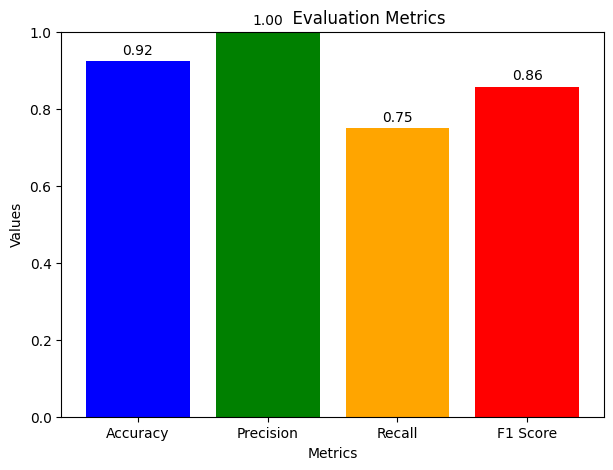

In [ ]:
categories = ["Accuracy", 'Precision', 'Recall', 'F1 Score']
values = [accuracy1, precision1, recal1, f1_score1]

plt.figure(figsize=(7,5))
bars = plt.bar(categories, values, color=['blue', 'green', 'orange', 'red'])

for bar, values in zip(bars, values):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{values:.2f}', ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('              Evaluation Metrics')
plt.ylim(0, 1)
plt.show()